In [ ]:
!pip install causalml sklearn

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from causalml.inference.meta import BaseXLearner
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt

In [2]:
from causalml.match import NearestNeighborMatch
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

In [3]:
from causalml.metrics import *

In [4]:
df = pd.read_csv("data2.csv")

In [5]:
#encoding gender column
df['gender'] = df['gender'].map({'male': 1, 'female': 0})

In [6]:
#cleaning if their is any missing values
for col in df.columns:
    if df[col].isnull().any():
        if not df[col].dropna().empty: 
            if df[col].dtype == 'object':
                df[col].fillna(df[col].mode()[0], inplace=True)
            else:
                df[col].fillna(df[col].mean(), inplace=True)

In [7]:
#normalizing age
scaler = StandardScaler()
df['age'] = scaler.fit_transform(df[['age']])

In [8]:
X = df[['age', 'gender']]    
treatment = df['treatment']   
y = df['outcome']  

In [9]:
#logical regretion for calculating psm score with the cofactors age and gender
model = LogisticRegression()
model.fit(X, treatment)
propensity_scores = model.predict_proba(X)[:, 1]

In [10]:
df['propensity_score'] = propensity_scores

In [11]:
#maching treated and controled with the psm score nearest neighbor  
matcher = NearestNeighborMatch(replace=False, ratio=1)
matched = matcher.match(
    data=df,
    treatment_col='treatment',
    score_cols=['propensity_score']
)

In [12]:
treated = matched[matched['treatment'] == 1]
control = matched[matched['treatment'] == 0]

In [13]:
ate = treated['outcome'].mean() - control['outcome'].mean() 

In [14]:
print(f"Estimated ATE after PSM: {ate:.4f}")

Estimated ATE after PSM: 5.0405


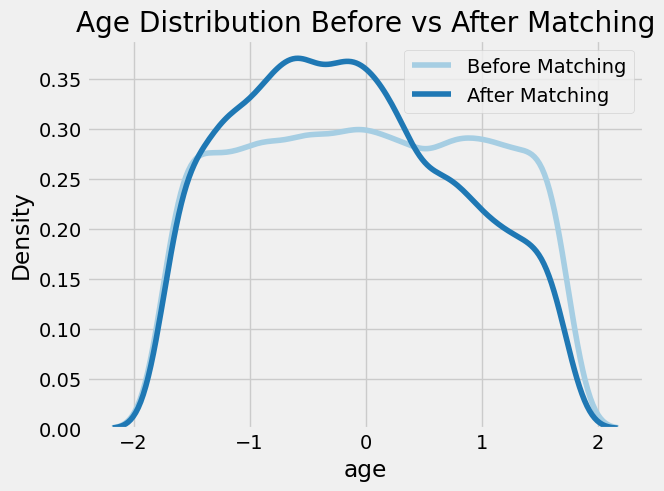

In [15]:
sns.kdeplot(df['age'], label='Before Matching')
sns.kdeplot(matched['age'], label='After Matching')
plt.legend()
plt.title("Age Distribution Before vs After Matching")
plt.show()

In [17]:
#double machine learning with causalML
#split the data first for the pridiction
from sklearn.model_selection import train_test_split
from causalml.inference.meta import BaseXRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import LogisticRegression, LassoCV
X_train, X_test, t_train, t_test, y_train, y_test = train_test_split(
    X, treatment, y, test_size=0.2, random_state=42
)